In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
from scipy.stats import chi2

## Parameter Settings

In [216]:
def corr2cov(corr, std):
    N_asset = len(std)
    cov = np.zeros((N_asset, N_asset))
    for i in range(N_asset):
        for j in range(N_asset):
            cov[i][j] = corr[i][j]*std[i]*std[j]
    return cov

In [215]:
#mu = np.array([0.0248, 0.0242])
#std = np.array([0.0042, 0.0033])
#corr = np.array([[1,0.7],[0.7,1]])
mu = np.array([.015617, .019477, .01907, .015801, .021643, .016010, .014892, .016248,.014075, .014537])
std = np.array([.088308, .084585, .01004, .086215, .059886, .068767, .058162, .056385, .080047, .082125])
corr = np.array([[ 1,  0.366, 0.3457,   0.1606,     0.2279,  0.5133,  0.5203,    0.2176,  0.3267,  0.5101], 
             [ 0.366,  1,  0.5379,    0.2165,  0.4986,   0.5823,  0.5569,    0.4760,  0.6517,  0.5853],
             [0.3457,  0.5379,   1,     0.2218,  0.4283,  0.4051,  0.4492,   0.3867,  0.4883,  0.6569],
             [0.1606,  0.2165,   0.2218, 1,    0.0569,  0.3609,  0.2325,    0.2289,  0.1726,  0.3814 ],
             [0.2279,  0.4986,   0.4283, 0.0569,  1,     0.3619,  0.4811,    0.5952,  0.4378,  0.4368],
             [0.5133,  0.5823,   0.4051, 0.3609,  0.3619,  1,     0.6167,    0.4996,  0.5811,  0.5644],
             [0.5203,  0.5569,   0.4492, 0.2325,  0.4811,  0.6167,  1,      0.6037,  0.5671,  0.6032 ],
             [0.2176,  0.4760,   0.3867, 0.2289,  0.5952,  0.4996,  0.6037,      1,  0.5012,  0.4772 ],
             [0.3267,  0.6517,   0.4883, 0.1726,  0.4378,  0.5811,  0.5671,    0.5012,  1,    0.6039 ],
             [ 0.5101, 0.5853,   0.6569, 0.3814,  0.4368,  0.5644,  0.6032,    0.4772,  0.6039,   1 ]])

In [217]:
cov = corr2cov(corr, std)

## Create Simulated Series

In [55]:
def simulate_series(true_mean, true_cov, N_obs = 100):
    simulate_return_series = []
    #Conduct Cholesky Decomposition on the true covariance matrix
    L = np.linalg.cholesky(true_cov)
    #Given the number of observation in a series
    N_asset = len(true_mean)
    for i in range(N_obs):
        Z = np.random.normal(size = N_asset)
        simulate_return_series.append(true_mean + np.dot(L, Z))
    return list(zip(*simulate_return_series))

In [218]:
rtn_series = simulate_series(mu, cov, N_obs = 100)

In [219]:
np.mean(rtn_series,axis = 1)

array([0.02003662, 0.01971414, 0.0203589 , 0.02992184, 0.02436103,
       0.02330986, 0.01588123, 0.01238487, 0.01676076, 0.01265124])

## Conduct Optimization and Draw Frontier Plot

In [231]:
def build_frontier(true_return, true_cov, estimated_return, sigma, risk_level, eta):
    
    N_asset = len(true_return)
    L = np.linalg.cholesky(true_cov)
    
    #Calculate true frontier
    c = matrix(-true_return)
    A = matrix(np.array([[1.0 for i in range(N_asset)]]), tc='d')
    b = matrix(np.array([1.0]), tc='d')
    
    Gl = matrix(np.diag([-1.0 for i in range(N_asset)]), tc='d')
    hl = matrix(np.array([0.0 for i in range(N_asset)]), tc='d')
    Gq = [matrix(np.vstack([np.array([0.0 for i in range(N_asset)]), (-1)*L]))]
    hq = [matrix(np.array([np.sqrt(risk_level)] + [0.0 for i in range(N_asset)]))]
    
    sol = solvers.socp(c, Gl = Gl, hl = hl, Gq = Gq, hq = hq, A = A, b = b)
    w_true = sol['x']
    
    r_true = -sol['primal objective']
    
    #Calculate estimated Markowitz frontier
    c = matrix(-estimated_return)
    A = matrix(np.array([[1.0 for i in range(N_asset)]]), tc='d')
    b = matrix(np.array([1.0]), tc='d')
    
    Gl = matrix(np.diag([-1.0 for i in range(N_asset)]), tc='d')
    hl = matrix(np.array([0.0 for i in range(N_asset)]), tc='d')
    Gq = [matrix(np.vstack([np.array([0.0 for i in range(N_asset)]), (-1)*L]))]
    hq = [matrix(np.array([np.sqrt(risk_level)] + [0.0 for i in range(N_asset)]))]
    
    sol = solvers.socp(c, Gl = Gl, hl = hl, Gq = Gq, hq = hq, A = A, b = b)
    w_estimated = sol['x']
    
    r_estimated = -sol['primal objective']
    
    #Calculate Actual Markowitz frontier
    r_actual = np.dot(true_return, w_estimated)[0]
    
    #Calculate Estimated Robust frontier
    kappa = np.sqrt(chi2.ppf(eta, df = N_asset))
    P = np.linalg.cholesky(sigma)
    
    c = matrix(np.append(-estimated_return, [kappa]))
    A = matrix(np.array([[1.0 for i in range(N_asset)] + [0.0]]), tc='d')
    b = matrix(np.array([1.0]), tc='d')
    
    Gl = matrix(np.diag([-1.0 for i in range(N_asset+1)]), tc='d')
    hl = matrix(np.array([0.0 for i in range(N_asset+1)]), tc='d')
    G_0 = np.hstack([(-1)*L, np.array([[0.0] for i in range(N_asset)])])
    G_0 = np.vstack([np.array([0.0 for i in range(N_asset+1)]), G_0])
    Gq = [matrix(G_0)]
    hq = [matrix(np.array([np.sqrt(risk_level)] + [0.0 for i in range(N_asset)]))]
    G_1 = np.hstack([(-1)*P, np.array([[0.0] for i in range(N_asset)])])
    G_1 = np.vstack([np.array([0.0 for i in range(N_asset)] + [-1.0]), G_1])
    Gq += [matrix(G_1)]
    hq += [matrix(np.array([0.0 for i in range(N_asset+1)]))]
    
    sol = solvers.socp(c, Gl = Gl, hl = hl, Gq = Gq, hq = hq, A = A, b = b)
    w_estimated_robust = sol['x'][:-1]
    
    r_estimated_robust= np.dot(estimated_return, w_estimated_robust)[0]
    
    #Calculate Actual Markowitz frontier
    r_actual_robust = np.dot(true_return, w_estimated_robust)[0]
    
    return (w_true, w_estimated, w_estimated_robust, 
            r_true, r_estimated, r_actual, r_estimated_robust, r_actual_robust)

In [232]:
risk_levels = np.arange(0.001, 0.007, 0.0001)
frontier = pd.DataFrame(data = None, index = [risk for risk in risk_levels],
                        columns = ['true frontier', 'estimated frontier', 'actual frontier',
                                   'estimated robust frontier', 'actual robust frontier'])

for risk in risk_levels:
    results = build_frontier(true_return = mu, true_cov = cov, estimated_return = np.mean(rtn_series,axis = 1), 
             sigma = np.diag(np.diag(cov/100)), risk_level = risk, eta = 0.95)
    frontier.loc[risk] = [results[i] for i in range(3,8)]

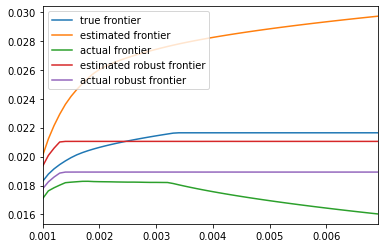

In [233]:
frontier.plot()